In [9]:
import numpy as np
import warnings
from corner import corner
from pathlib import Path
import pandas as pd
import logging
import arviz as az

from data import dataloader
from models.model import Model
from models.helpers.results import Results
import matplotlib.pyplot as plt
from scipy import stats as st

# warnings.filterwarnings("ignore", category=RuntimeWarning, module="emcee")
# warnings.filterwarnings("ignore", module="corner")
# warnings.filterwarnings("ignore", category=UserWarning, module="arviz")
# warnings.filterwarnings("ignore", category=RuntimeWarning, module="arviz")
# warnings.filterwarnings("ignore", module="emcee")

RESULTS_PATH = Path("./results")
FIGURES_PATH = Path("./figures")

$$ \mu(z; \Omega_{m,0}) = m_B - (M_B + \alpha \cdot x + \beta \cdot c + \Delta m_*) + \epsilon $$

More useful for MCMC is to rewrite this in the form of "true = model + error". Note the sign for the error
term doesn't matter.

$$ m_B = [\mu(z; \Omega_{m,0}) + M_B + \alpha \cdot x + \beta \cdot c + \Delta m_*] + \epsilon $$

In [11]:
dataloader.get_jla()

,#name,redshift,zhel,dz,mag,mag_sigma,stretch,stretch_sigma,color,color_sigma,...,host_mass_sigma,tmax,dtmax,cov_m_s,cov_m_c,cov_s_c,set,ra,dec,biascor
0,03D1au,0.503084,0.504300,0,23.001698,0.088031,1.273191,0.150058,-0.012353,0.030011,...,0.110500,52909.745220,0.214332,0.000790,0.000440,-0.000030,1,36.043210,-4.037469,0.001697
1,03D1aw,0.580724,0.582000,0,23.573937,0.090132,0.974346,0.273823,-0.025076,0.036691,...,0.088000,52902.898002,0.352732,0.002823,0.000415,0.001574,1,36.061634,-4.517158,0.000843
2,03D1ax,0.494795,0.496000,0,22.960139,0.088110,-0.728837,0.102069,-0.099683,0.030305,...,0.112500,52915.923670,0.111634,0.000542,0.000475,-0.000024,1,36.097287,-4.720774,0.001692
3,03D1bp,0.345928,0.347000,0,22.398137,0.087263,-1.155110,0.112834,-0.040581,0.026679,...,0.123500,52920.249015,0.102828,0.001114,0.000616,0.000295,1,36.657235,-4.838779,-0.000270
4,03D1co,0.677662,0.679000,0,24.078115,0.098356,0.618820,0.404295,-0.039380,0.067403,...,0.284000,52954.458342,0.454715,0.011857,0.000780,0.005898,1,36.567748,-4.935050,-0.002855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,sn2007co,0.027064,0.026962,0,16.504006,0.141685,-0.137806,0.061153,0.105288,0.020382,...,0.280891,54265.212054,0.056635,0.000095,0.000377,0.000007,3,275.765000,29.897050,-0.009803
736,sn2007cq,0.025468,0.025918,0,15.797848,0.143429,-0.657941,0.115645,-0.060805,0.025820,...,0.280891,54281.025669,0.070944,0.000392,0.000639,0.000075,3,333.668430,5.080160,-0.009575
737,sn2007f,0.023810,0.023590,0,15.895501,0.144315,0.618766,0.041400,-0.055411,0.026006,...,0.118500,54124.058397,0.045234,-0.000055,0.000645,-0.000180,3,195.812750,50.618760,-0.009361
738,sn2007qe,0.023867,0.024000,0,16.068268,0.144350,0.760605,0.045650,0.052186,0.026200,...,5.000000,54429.852171,0.037486,0.000101,0.000654,-0.000076,3,358.553990,27.409170,-0.009368


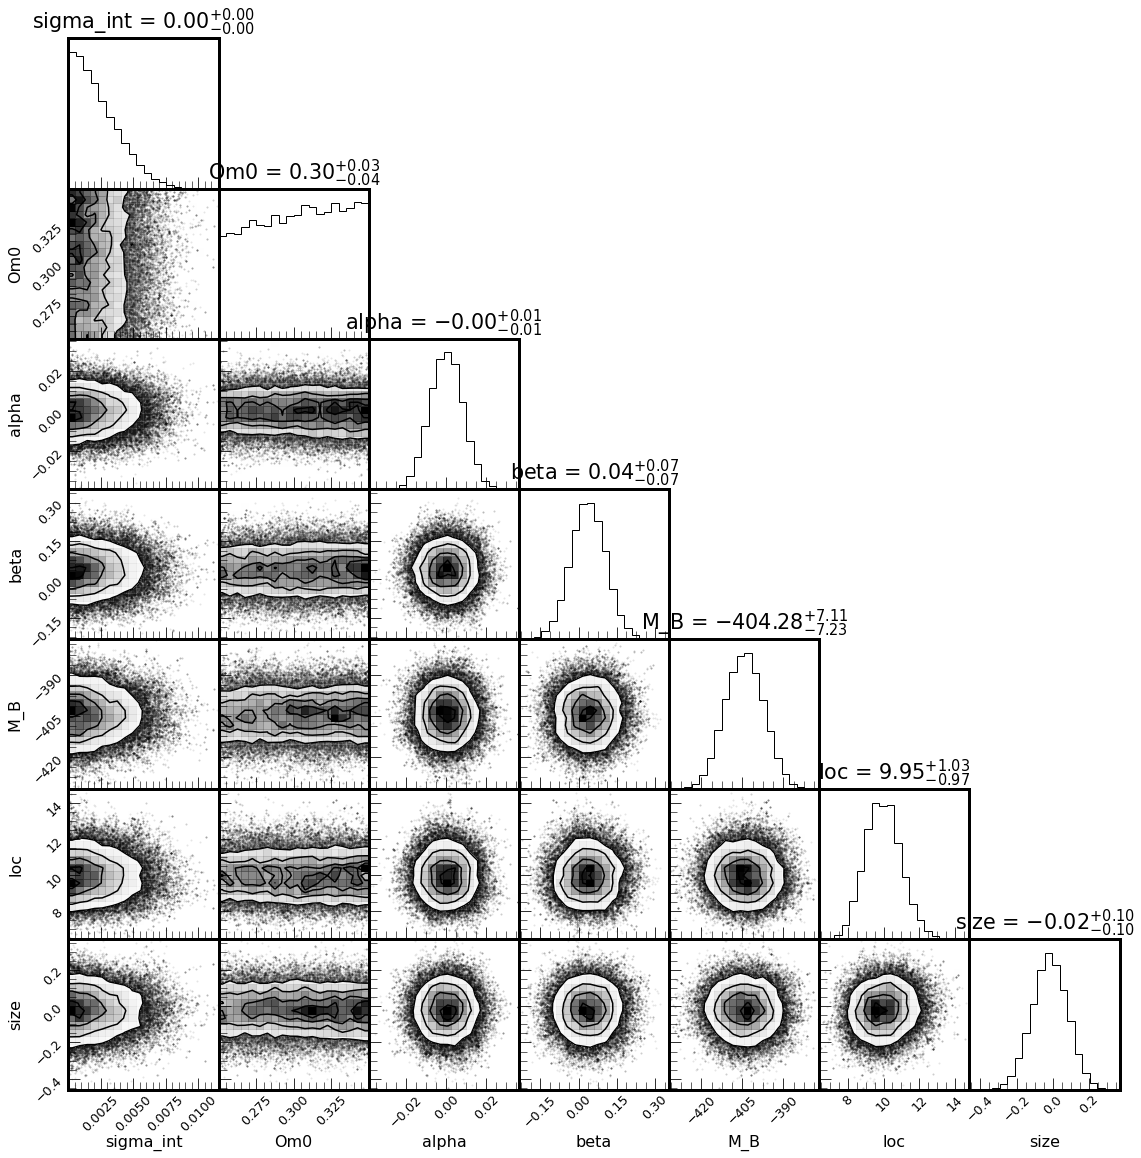

In [6]:
r = Results("results/jla-chi2/results_2021-08-08T0525.hd5")

r.plot_corner()


# Summary Table

In [4]:
def create_row(data_name, data, results_fpath):
    model = Model(H0=70, host_mass_correction_model="step")  # TODO: infer from results file
    
    r = Results(results_fpath, model=model)

    row={}
    row["Data"] = data_name
    row["Mass Correction Model"] = r.model.host_mass_correction_model
    
    savepath = FIGURES_PATH / r.results_fpath.parent.relative_to(RESULTS_PATH)
    savepath.mkdir(exist_ok=True, parents=True)

    r.plot_corner()
    savefile = savepath / f"{r.results_fpath.stem}_corner.pdf"
    plt.savefig(savefile)
    row["Corner Plot"] = f"[pdf](./{savefile})"
    plt.close()

    r.plot_hr_vs_host_mass(data)
    savefile = savepath / f"{r.results_fpath.stem}_hr.pdf"
    plt.savefig(savefile)
    row["HR Plot"] = f"[pdf](./{savefile})"
    plt.close()
    
    return row

def create_table():
    df = pd.DataFrame(columns=["Data", "Mass Correction Model", "Corner Plot", "HR Plot"])

    # JLA
    row = create_row(
        data_name="JLA",
        data=dataloader.get_jla(),
        results_fpath = sorted(list((RESULTS_PATH / "jla").glob("*.hd5")))[-1]
    )
    df = df.append(row, ignore_index=True)

    # ZPEG
    for i in range(1, 16+1):
        glob = list((RESULTS_PATH / f"zpeg/{i}").glob("*.hd5"))
        if not glob:
            continue

        row = create_row(
            data_name=f"ZPEG_{i}",
            data=dataloader.get_zpeg(i),
            results_fpath = sorted(glob)[-1]
        )
        df = df.append(row, ignore_index=True)
        
    # Prospector
    row = create_row(
        data_name="prospector",
        data=dataloader.get_prospector(),
        results_fpath = sorted(list((RESULTS_PATH / "jla").glob("*.hd5")))[-1]
    )
    df = df.append(row, ignore_index=True)
        
    return df
        
with warnings.catch_warnings():
    logging.basicConfig(level=logging.ERROR)
    warnings.simplefilter('ignore')
    df = create_table()
    
from IPython.display import Markdown
md = df.to_markdown()

with open("./model_results.md", "w") as f:
    f.write(md)

display(Markdown(md))

|    | Data       | Mass Correction Model   | Corner Plot                                               | HR Plot                                               |
|---:|:-----------|:------------------------|:----------------------------------------------------------|:------------------------------------------------------|
|  0 | JLA        | step                    | [pdf](figures/jla/results_2021-08-04T0723_corner.pdf)     | [pdf](figures/jla/results_2021-08-04T0723_hr.pdf)     |
|  1 | ZPEG_1     | step                    | [pdf](figures/zpeg/1/results_2021-08-05T0325_corner.pdf)  | [pdf](figures/zpeg/1/results_2021-08-05T0325_hr.pdf)  |
|  2 | ZPEG_2     | step                    | [pdf](figures/zpeg/2/results_2021-08-05T0325_corner.pdf)  | [pdf](figures/zpeg/2/results_2021-08-05T0325_hr.pdf)  |
|  3 | ZPEG_3     | step                    | [pdf](figures/zpeg/3/results_2021-08-05T0325_corner.pdf)  | [pdf](figures/zpeg/3/results_2021-08-05T0325_hr.pdf)  |
|  4 | ZPEG_13    | step                    | [pdf](figures/zpeg/13/results_2021-08-05T0205_corner.pdf) | [pdf](figures/zpeg/13/results_2021-08-05T0205_hr.pdf) |
|  5 | ZPEG_14    | step                    | [pdf](figures/zpeg/14/results_2021-08-05T0205_corner.pdf) | [pdf](figures/zpeg/14/results_2021-08-05T0205_hr.pdf) |
|  6 | ZPEG_15    | step                    | [pdf](figures/zpeg/15/results_2021-08-05T0205_corner.pdf) | [pdf](figures/zpeg/15/results_2021-08-05T0205_hr.pdf) |
|  7 | ZPEG_16    | step                    | [pdf](figures/zpeg/16/results_2021-08-05T0205_corner.pdf) | [pdf](figures/zpeg/16/results_2021-08-05T0205_hr.pdf) |
|  8 | prospector | step                    | [pdf](figures/jla/results_2021-08-04T0723_corner.pdf)     | [pdf](figures/jla/results_2021-08-04T0723_hr.pdf)     |